In [16]:
##Our import: 
import nltk
from nltk.probability import ConditionalFreqDist
import pandas as pd
import math
from nltk import word_tokenize
import numpy as np


##Our defines: 
q1Verbose=1

### Q1. Document Classification
#### Q1.1. Reuters Dataset

##### Q1.1.1 Turn the code of the Sklearn tutorial above into a notebook.

This code is taken from the out of core classification guide given in the assigmnent. 
http://scikit-learn.org/dev/auto_examples/applications/plot_out_of_core_classification.html#example-applications-plot-out-of-core-classification-py


Test set is 878 documents (108 positive)
      NB Multinomial classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.877 in 5.51s (  174 docs/s)
          Perceptron classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.912 in 5.55s (  173 docs/s)
  Passive-Aggressive classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.936 in 5.56s (  172 docs/s)
                 SGD classifier : 	   962 train docs (   132 positive)    878 test docs (   108 positive) accuracy: 0.919 in 5.58s (  172 docs/s)


      NB Multinomial classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.885 in 16.11s (  242 docs/s)
          Perceptron classifier : 	  3911 train docs (   517 positive)    878 test docs (   108 positive) accuracy: 0.946 in 16.12s (  242 docs/s)
  Passive-Aggressive classifier : 	  3911 train docs (   517 positive)    878 t

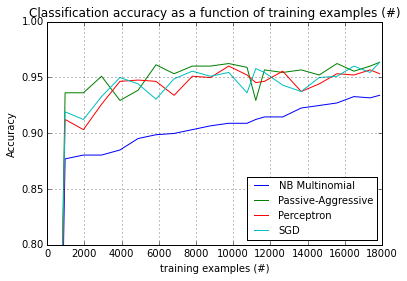

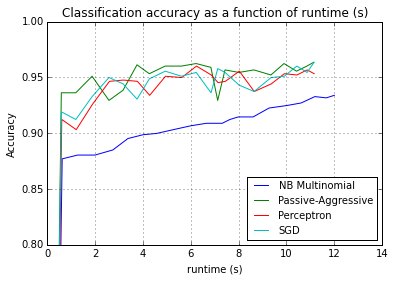

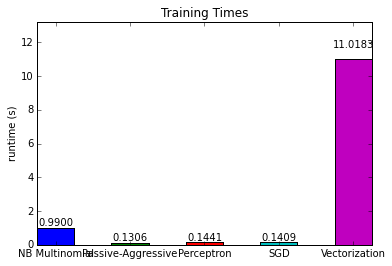

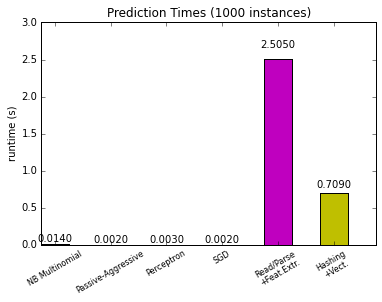

In [11]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

%matplotlib inline
###############################################################################
# Reuters Dataset related routines
###############################################################################


class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc


###############################################################################
# Main
###############################################################################
# Create the vectorizer and limit the number of features to a reasonable
# maximum
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batchs of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')


###############################################################################
# Plot results
###############################################################################


def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
#fig = plt.gcf()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')
bar_colors = rcParams['axes.color_cycle'][:len(cls_names)]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

##### Q1.1.2 Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (Hint: use the pandas library to explore the dataset, use the dataframe.describe() method.)


In [12]:
#From the code, accessing the reuters document data base. 
data_stream = stream_reuters_documents()
#Experimenting with functions given in hint. 
df = pd.DataFrame(data_stream)
print("The type of df is: ", type(df))
df

The type of df is:  <class 'pandas.core.frame.DataFrame'>


body  \
0      Showers continued throughout the week in the B...   
1      Standard Oil Co and BP North America Inc said ...   
2      Texas Commerce Bancshares Inc's Texas Commerce...   
3      BankAmerica Corp is not under pressure to act ...   
4      The U.S. Agriculture Department reported the f...   
5      Argentine grain board figures show crop regist...   
6      Red Lion Inns Limited Partnership said it file...   
7      Moody's Investors Service Inc said it lowered ...   
8      Champion Products Inc said its board of direct...   
9      Computer Terminal Systems Inc said it has comp...   
10     Shr 34 cts vs 1.19 dlrs Net 807,000 vs 2,858,0...   
11     Ohio Mattress Co said its first quarter, endin...   
12     Oper shr loss two cts vs profit seven cts Oper...   
13     Shr one dlr vs 73 cts Net 12.6 mln vs 15.8 mln...   
14     National Intergroup Inc said it plans to file ...   
15     BankAmerica Corp is not under pressure to act ...   
16     National Health Enhancement Systems Inc said i...   
17     Dean Foods Co expects earnings for the fourth ...   
18     The Commodity Credit Corporation, CCC, has acc...   
19     Legislation to require disclosure of credit ca...   
20     Hughes/Conserdyne Corp, a unit of <Hughes Capi...   
21     Magma Copper Co, a subsidiary of Newmont Minin...   
22     Brown-Forman Inc said its board has approved a...   
23     Shr profit 15 cts vs profit four cts Annual di...   
24     Shearson Lehman Brothers, a unit of American E...   
25     Venezuela and its bank advisory committee have...   
26     Shr 39 cts vs 50 cts Net 1,545,160 vs 2,188,93...   
27     The Tower Commission report, which says Presid...   
28     Sales of previously owned homes dropped 14.5 p...   
29                                                         
...                                                  ...   
21548  TDK Corp <TDK.T> said its sales rose 3.6 pct i...   
21549  Cable and Wireless Plc <CAWL.L> said it will m...   
21550  Nine months ended August 31 Group shr 118.66 y...   
21551                                                      
21552  Third quarter ended August 31 Group shr 34.92 ...   
21553                                                      
21554                                                      
21555  French Finance Minister Edouard Balladur issue...   
21556  International Rubber Organisation (INRO) buffe...   
21557  Continental Airlines Inc said Frontier Airline...   
21558                                                      
21559  Nippon Shinpan Co Ltd <NSHT.T> has agreed with...   
21560  An income tax surcharge and capital gains tax ...   
21561  The Philippines' trade deficit widened to 542 ...   
21562  Iranian President Ali Khamenei said he doubted...   
21563                                                      
21564  New Zealand has imposed sanctions against Fiji...   
21565  The Ministry of Finance has started to conside...   
21566  Uganda plans to export roasted coffee to Europ...   
21567  The Soviet Union has agreed to supply Iran wit...   
21568  Orders for non-fuel imports placed in August r...   
21569  Thai rice exports rose to 72,987 tonnes in the...   
21570  Chase Corp Ltd <CHCA.WE> said it will make an ...   
21571  An announcement by Alliant Computer Systems In...   
21572  Tokyo's foreign exchange market is watching ne...   
21573  The Japan/India-Pakistan-Gulf/Japan shipping c...   
21574  The Soviet Union's industrial output is growin...   
21575  Six black miners have been killed and two inju...   
21576  The prospect of a dominant alliance of sociali...   
21577  The American Stock Exchange said it has introd...   

                                                   title  \
0                                     BAHIA COCOA REVIEW   
1              STANDARD OIL <SRD> TO FORM FINANCIAL UNIT   
2             TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN   
3           TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER   
4       NATIONAL AVERAGE PRICES

#### How many documents in the dataset? 

In [17]:
df['title'].describe()['count']

21578

There are 21,578 as seen below. 

In [18]:
#Some exploring of dataset: 
if q1Verbose:
    print(list(df))
    print(df['body'].describe())
    # Since df['topics'].descibe() does not work, let's just print. 
    print(df['topics'])
    print(type(df['topics']))

['body', 'title', 'topics']
count     21578
unique    18763
top            
freq       2535
Name: body, dtype: object
0                       [cocoa, el-salvador, usa, uruguay]
1                                                    [usa]
2                                                    [usa]
3                                            [usa, brazil]
4          [grain, wheat, corn, barley, oat, sorghum, usa]
5        [veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...
6                                                    [usa]
7                                                    [usa]
8                                              [earn, usa]
9                                               [acq, usa]
10                                             [earn, usa]
11                                        [earn, acq, usa]
12                                             [earn, usa]
13                                             [earn, usa]
14                                                   [us

#### Each document can belong to a few topics (we interperted topics for categories). We will feed all information into a FreqDist and receive statistics.

As implied, this means a document can appear in several documents. 

In [ ]:
#Create a list of all occurences of all topics and feed to FreqDist. 
freq_dist = nltk.FreqDist(sum(list(df['topics']), []))

#### How many categories: 

In [ ]:
category_set=set(sum(list(df['topics']), []))
num_of_categories = len(category_set)
print("The number of categories is: ",num_of_categories)

Since we are using a Frequency distribution, the number of categories can also be retrieved by: 


In [ ]:
len(freq_dist)

#### How many documents per category: 
Since we are using a Frequency distribution, the number of documents per category 
is the value in freq_dist[category]. 

We can print a list of all categories and the number of documents in them. 

In [ ]:
cat_numOfDocs = [(category, freq_dist[category]) for category in category_set]
for pair in cat_numOfDocs[:10]: 
    print('Category: ', pair[0], 'has ', pair[1], 'Docs')

####  Provide mean and standard deviation, min and max. 
Mean: Mean number of documents per categorie. 

In [ ]:
[num_of_docs for _, num_of_docs in cat_numOfDocs]

In [ ]:
#Mean: 
#Sum of number of documents per each category. 
sum_docs_cat = sum(num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#
#Mean expected number of documents per categorie. 
#mean_exp=sum(freq_dist.freq(cat)*num_of_docs for (cat, num_of_docs) in cat_numOfDocs)
#mean2 = np.mean([num_of_docs for _, num_of_docs in cat_numOfDocs])
#print('The Mean number of documents per categorie is: ', mean_exp)
#print('The Mean2 number of documents per categorie is: ', mean2)
print('The Average number of documents per categories is: ', sum_docs_cat / len(cat_numOfDocs))
# Max:
print('The categories with maximum documents is: "', freq_dist.max(), '"which has ', freq_dist[freq_dist.max()],
      ' documents.')

# Min:
min_num_of_docs = sorted(cat_numOfDocs, key=lambda x: x[1])[0][1]
cats_w_min_num_of_docs = [cat for (cat, num_of_docs) in cat_numOfDocs if num_of_docs == min_num_of_docs]
display = 3  # Display only part of categories, not all.
print('The category with minimum documents are:', cats_w_min_num_of_docs[:display], 'who have', min_num_of_docs,
      'documents each. ')

# Standard deviation:
std_dev = math.sqrt(
    sum((math.pow(num_of_docs - mean_exp, 2) for (_, num_of_docs) in cat_numOfDocs)) / len(cat_numOfDocs))
print('The standard deviation in number of documents per category is:', std_dev)

#### Q1.1.3 Explore how many characters and words are present in the documents of the dataset.


In [ ]:
#Takes a while to run, use with care :)
word_set=set()
for i in range(len(df['body'])): 
    word_set.update(word_tokenize(df['body'][i]))

#for i in range(len(df['body']))


In [ ]:

char_set=set(sum(list(word), []) for word in word_set)
char_set

#F

### Q2. Named Entity Recognition
    Features:
            we are intrested in creating a vectorized obejct from our data set, which will take into consideration the
            (1) word form the (2)POS of the word (3) ORT, (4) perfix1 ,(5) perfix2, (6) perfix3, (7) suffix1 
            (8) suffix2, (9) suffix3

#### 2.1 Features